In [30]:
import pandas as pd
import numpy as np
import cv2    
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score

from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img 
from keras.utils import np_utils
from keras.optimizers import SGD

from IPython.core.display import display, HTML
from PIL import Image
from io import BytesIO
import base64

plt.style.use('ggplot')

%matplotlib inline

In [31]:
import tensorflow as tf
print(tf.__version__)

2.4.1


In [32]:

images_folder = 'J://sir_dataset//img_align_celeba.csv//img_align_celeba'

EXAMPLE_PIC = images_folder + '//000506.jpg'

TRAINING_SAMPLES = 10000
VALIDATION_SAMPLES = 2000
TEST_SAMPLES = 2000
IMG_WIDTH = 178
IMG_HEIGHT = 218
BATCH_SIZE = 16
NUM_EPOCHS = 20

In [33]:
!pip install fsspec

You are using pip version 9.0.1, however version 21.0.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [34]:
df_attr = pd.read_csv('J://sir_dataset//list_attr_celeba.csv')
df_attr.set_index('image_id', inplace=True)
df_attr.replace(to_replace=-1, value=0, inplace=True) #replace -1 by 0
df_attr.shape

(202599, 40)

In [35]:
for i, j in enumerate(df_attr.columns):
    print(i, j)

0 5_o_Clock_Shadow
1 Arched_Eyebrows
2 Attractive
3 Bags_Under_Eyes
4 Bald
5 Bangs
6 Big_Lips
7 Big_Nose
8 Black_Hair
9 Blond_Hair
10 Blurry
11 Brown_Hair
12 Bushy_Eyebrows
13 Chubby
14 Double_Chin
15 Eyeglasses
16 Goatee
17 Gray_Hair
18 Heavy_Makeup
19 High_Cheekbones
20 Male
21 Mouth_Slightly_Open
22 Mustache
23 Narrow_Eyes
24 No_Beard
25 Oval_Face
26 Pale_Skin
27 Pointy_Nose
28 Receding_Hairline
29 Rosy_Cheeks
30 Sideburns
31 Smiling
32 Straight_Hair
33 Wavy_Hair
34 Wearing_Earrings
35 Wearing_Hat
36 Wearing_Lipstick
37 Wearing_Necklace
38 Wearing_Necktie
39 Young


In [36]:
img = cv2.imread(EXAMPLE_PIC)
#plt.grid(False)

#cv2.imshow('img',img)
#cv2.waitKey()
df_attr.loc[EXAMPLE_PIC.split('/')[-1]][['Smiling','Male','Young']] 


Smiling    1
Male       0
Young      1
Name: 000506.jpg, dtype: int64

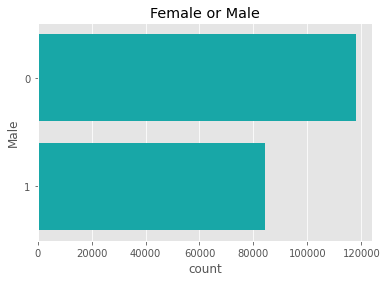

In [37]:
plt.title('Female or Male')
sns.countplot(y='Male', data=df_attr, color="c")
plt.show()

In [38]:
df_partition = pd.read_csv('J://sir_dataset//list_eval_partition.csv')
df_partition.head()

,image_id,partition
0,000001.jpg,0
1,000002.jpg,0
2,000003.jpg,0
3,000004.jpg,0
4,000005.jpg,0


In [39]:
df_partition['partition'].value_counts().sort_index()

0    162770
1     19867
2     19962
Name: partition, dtype: int64

In [40]:
df_partition.set_index('image_id', inplace=True)
df_par_attr = df_partition.join(df_attr['Male'], how='inner')
df_par_attr.head()

,partition,Male
image_id,,
000001.jpg,0,0
000002.jpg,0,0
000003.jpg,0,1
000004.jpg,0,0
000005.jpg,0,0


In [41]:
def load_reshape_img(fname):
    img = load_img(fname)
    x = img_to_array(img)/255.
    x = x.reshape((1,) + x.shape)

    return x


def generate_df(partition, attr, num_samples):
    '''
    partition
        0 -> train
        1 -> validation
        2 -> test
    
    '''
    
    df_ = df_par_attr[(df_par_attr['partition'] == partition) 
                           & (df_par_attr[attr] == 0)].sample(int(num_samples/2))
    df_ = pd.concat([df_,
                      df_par_attr[(df_par_attr['partition'] == partition) 
                                  & (df_par_attr[attr] == 1)].sample(int(num_samples/2))])

    # for Train and Validation
    if partition != 2:
        x_ = np.array([load_reshape_img('J://sir_dataset//img_align_celeba.csv//img_align_celeba//'+fname) for fname in df_.index])
        x_ = x_.reshape(x_.shape[0], 218, 178, 3)
        y_ = np_utils.to_categorical(df_[attr],2)
    # for Test
    else:
        x_ = []
        y_ = []

        for index, target in df_.iterrows():
            im = cv2.imread(index)
            im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), (IMG_WIDTH, IMG_HEIGHT)).astype(np.float32) / 255.0
            im = np.expand_dims(im, axis =0)
            x_.append(im)
            y_.append(target[attr])

    return x_, y_

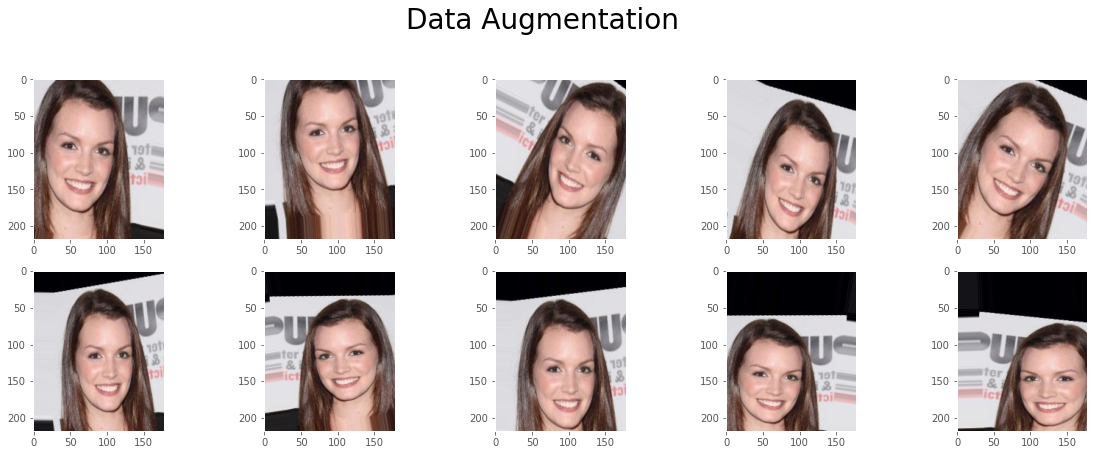

In [42]:
datagen = ImageDataGenerator(
  #preprocessing_function=preprocess_input,
  rotation_range=30,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True
)

# load one image and reshape
img = load_img(EXAMPLE_PIC)
x = img_to_array(img)/255.
x = x.reshape((1,) + x.shape)

# plot 10 augmented images of the loaded iamge
plt.figure(figsize=(20,10))
plt.suptitle('Data Augmentation', fontsize=28)

i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.subplot(3, 5, i+1)
    plt.grid(False)
    plt.imshow( batch.reshape(218, 178, 3))
    
    if i == 9:
        break
    i += 1
    
plt.show()


In [43]:
x_train, y_train = generate_df(0, 'Male', TRAINING_SAMPLES)

# Train - Data Preparation - Data Augmentation with generators
train_datagen =  ImageDataGenerator(
  preprocessing_function=preprocess_input,
  rotation_range=30,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True,
)

train_datagen.fit(x_train)

train_generator = train_datagen.flow(
x_train, y_train,
batch_size=BATCH_SIZE,
)

In [44]:
x_valid, y_valid = generate_df(1, 'Male', VALIDATION_SAMPLES)

In [45]:
inc_model = InceptionV3(weights='J:\sir_dataset\inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        include_top=False,
                        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
print("number of layers:", len(inc_model.layers))

number of layers: 311


In [46]:
x = inc_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(512, activation="relu")(x)
predictions = Dense(2, activation="softmax")(x)

In [47]:
model_ = Model(inputs=inc_model.input, outputs=predictions)

# Lock initial layers to do not be trained
for layer in model_.layers[:52]:
    layer.trainable = False

# compile the model
model_.compile(optimizer=SGD(lr=0.0001, momentum=0.9)
                    , loss='categorical_crossentropy'
                    , metrics=['accuracy'])

In [48]:
checkpointer = ModelCheckpoint(filepath='weights.best.inc.male.hdf5', 
                               verbose=1, save_best_only=True)

In [49]:
hist = model_.fit_generator(train_generator
                     , validation_data = (x_valid, y_valid)
                      , steps_per_epoch= TRAINING_SAMPLES/BATCH_SIZE
                      , epochs= NUM_EPOCHS
                      , callbacks=[checkpointer]
                      , verbose=1
                    )

c:\python36\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
625/625 [==============================] - 765s 1s/step - loss: 0.6901 - accuracy: 0.5593 - val_loss: 0.8086 - val_accuracy: 0.5285

Epoch 00001: val_loss improved from inf to 0.80855, saving model to weights.best.inc.male.hdf5
Epoch 2/20
625/625 [==============================] - 736s 1s/step - loss: 0.5238 - accuracy: 0.7396 - val_loss: 0.9826 - val_accuracy: 0.4930

Epoch 00002: val_loss did not improve from 0.80855
Epoch 3/20
625/625 [==============================] - 764s 1s/step - loss: 0.4388 - accuracy: 0.7963 - val_loss: 0.9734 - val_accuracy: 0.5085

Epoch 00003: val_loss did not improve from 0.80855
Epoch 4/20
625/625 [==============================] - 750s 1s/step - loss: 0.3971 - accuracy: 0.8185 - val_loss: 1.0462 - val_accuracy: 0.5075

Epoch 00004: val_loss did not improve from 0.80855
Epoch 5/20
625/625 [==============================] - 737s 1s/step - loss: 0.3620 - accuracy: 0.8422 - val_loss: 1.1612 - val_accuracy: 0.4995

Epoch 00005: val_loss did not im

In [50]:
model_.save('age_model')

INFO:tensorflow:Assets written to: age_model\assets


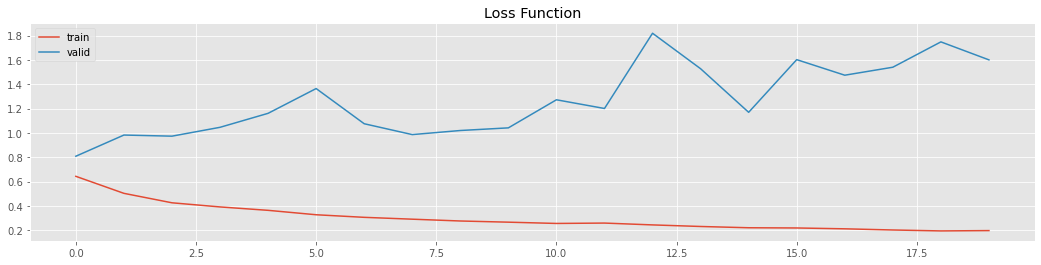

In [51]:
plt.figure(figsize=(18, 4))
plt.plot(hist.history['loss'], label = 'train')
plt.plot(hist.history['val_loss'], label = 'valid')
plt.legend()
plt.title('Loss Function')
plt.show()

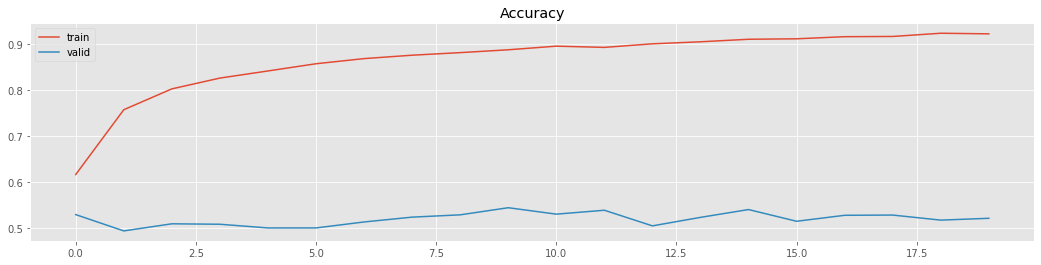

In [52]:

plt.figure(figsize=(18, 4))
plt.plot(hist.history['accuracy'], label = 'train')
plt.plot(hist.history['val_accuracy'], label = 'valid')
plt.legend()
plt.title('Accuracy')
plt.show()

In [53]:
model_.load_weights('J:\sir_dataset\weights.best.inc.male.hdf5')

In [54]:
im = cv2.imread('J://sir_dataset//img_align_celeba.csv//img_align_celeba//000007.jpg')
im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), (IMG_WIDTH, IMG_HEIGHT)).astype(np.float32) / 255.0

In [55]:
x_test=im.reshape(1,218,178,3)
x_test.shape

(1, 218, 178, 3)

In [56]:
result=model_.predict(x_test)

In [57]:
def capture():
    video = cv2.VideoCapture(0)
    start = time.time()

    while True:
        check, frame = video.read()
        if time.time() - start > 2:
            break

    return frame

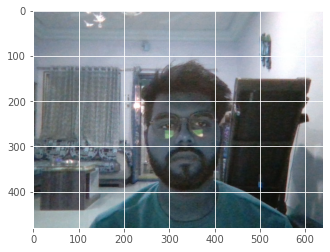

In [58]:
import time
frame=capture()
plt.imshow(frame)

In [59]:
img=cv2.resize(frame,(218,178))


In [60]:
x_test=img.reshape(1,218,178,3)
x_test=x_test/255.0

In [61]:
result=model_.predict(x_test)

In [62]:
if result[0][0]>0.5:
    print('female')
else:
    print('male')
 
    

male
